# 1. Introduction

 This notebook outlines the creation, compilation, and training of a deep learing network using the [TorchKit](https://github.com/sergio-sanz-rodriguez/TorchKit) framework. In particular, a Vision Transformer (ViT) will be used to classify 101 types of food from the following dataset: https://huggingface.co/datasets/ethz/food101.
 
 The following table summarizes the model:

| Version | **ViT Type** | **Image Size** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Hidder Layer Units for Classification** | **Transfer Learning** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 1 | Base | 384x384 | 16x16 | 12 | 768 | 3072 | 12 | 64 | IMAGENET1K_SWAG_E2E_V1 | 60 | 0.0001 | CosineAnnealingLR | 86.2M |

The custom vision transformer architectures have been implemented from scratch based on the paper titled ["An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale"](https://arxiv.org/abs/2010.11929). The custom library is called **vision_transformer** where the **ViT class** can be imported.

# 2. Importing Libraries

In [1]:
import os
import torch
import torchvision
import torch.backends.cudnn as cudnn

from torchvision.transforms import v2
from torchinfo import summary
from pathlib import Path
from torchvision import datasets
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

# Import custom libraries
from helper_functions import set_seeds, display_random_images
from engine import ClassificationEngine
from vision_transformer import ViT
from schedulers import FixedLRSchedulerWrapper
from dataloaders import create_dataloaders_vit

# Dataset
from datasets import load_dataset

# 3. Importing Dataset

In [ ]:
# Download dataset from Hugging Face
ds = load_dataset("ethz/food101")

In [2]:
# Define some constants
NUM_WORKERS = os.cpu_count()
AMOUNT_TO_GET = 1.0
SEED = 42

# Define target data directory
TARGET_DIR_NAME = f"data/food-101_{str(int(AMOUNT_TO_GET*100))}_percent"

# Setup training and test directories
TARGET_DIR = Path(TARGET_DIR_NAME)
TRAIN_DIR = TARGET_DIR / "train"
TEST_DIR = TARGET_DIR / "test"
TARGET_DIR.mkdir(parents=True, exist_ok=True)

# Create target model directory
MODEL_DIR = Path("models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Set seeds
set_seeds(SEED)

In [ ]:
# Get class names
class_names = ds["train"].features["label"].names

# Function to save images into appropriate directories
def save_images(split, target_dir):
    for example in tqdm(ds[split], desc=f"Saving {split} images"):
        image = example["image"]
        label = example["label"]
        class_name = class_names[label]

        # Define class directory
        class_dir = target_dir / class_name
        class_dir.mkdir(parents=True, exist_ok=True)

        # Save image
        img_path = class_dir / f"{len(list(class_dir.iterdir()))}.jpg"
        image.save(img_path)

# Save training and test images
save_images("train", TRAIN_DIR)
save_images("validation", TEST_DIR)

print("Dataset has been saved successfully!")

# 4. Specifying the Target Device

In [3]:
# Activate cuda benchmark
cudnn.benchmark = True

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

if device == "cuda":
    !nvidia-smi

Device: cuda
Fri Feb  7 18:58:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  |   00000000:01:00.0  On |                  N/A |
| 30%   44C    P8             10W /  200W |    1216MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N/A |
+----------------------------------

# 5. Image Visualization

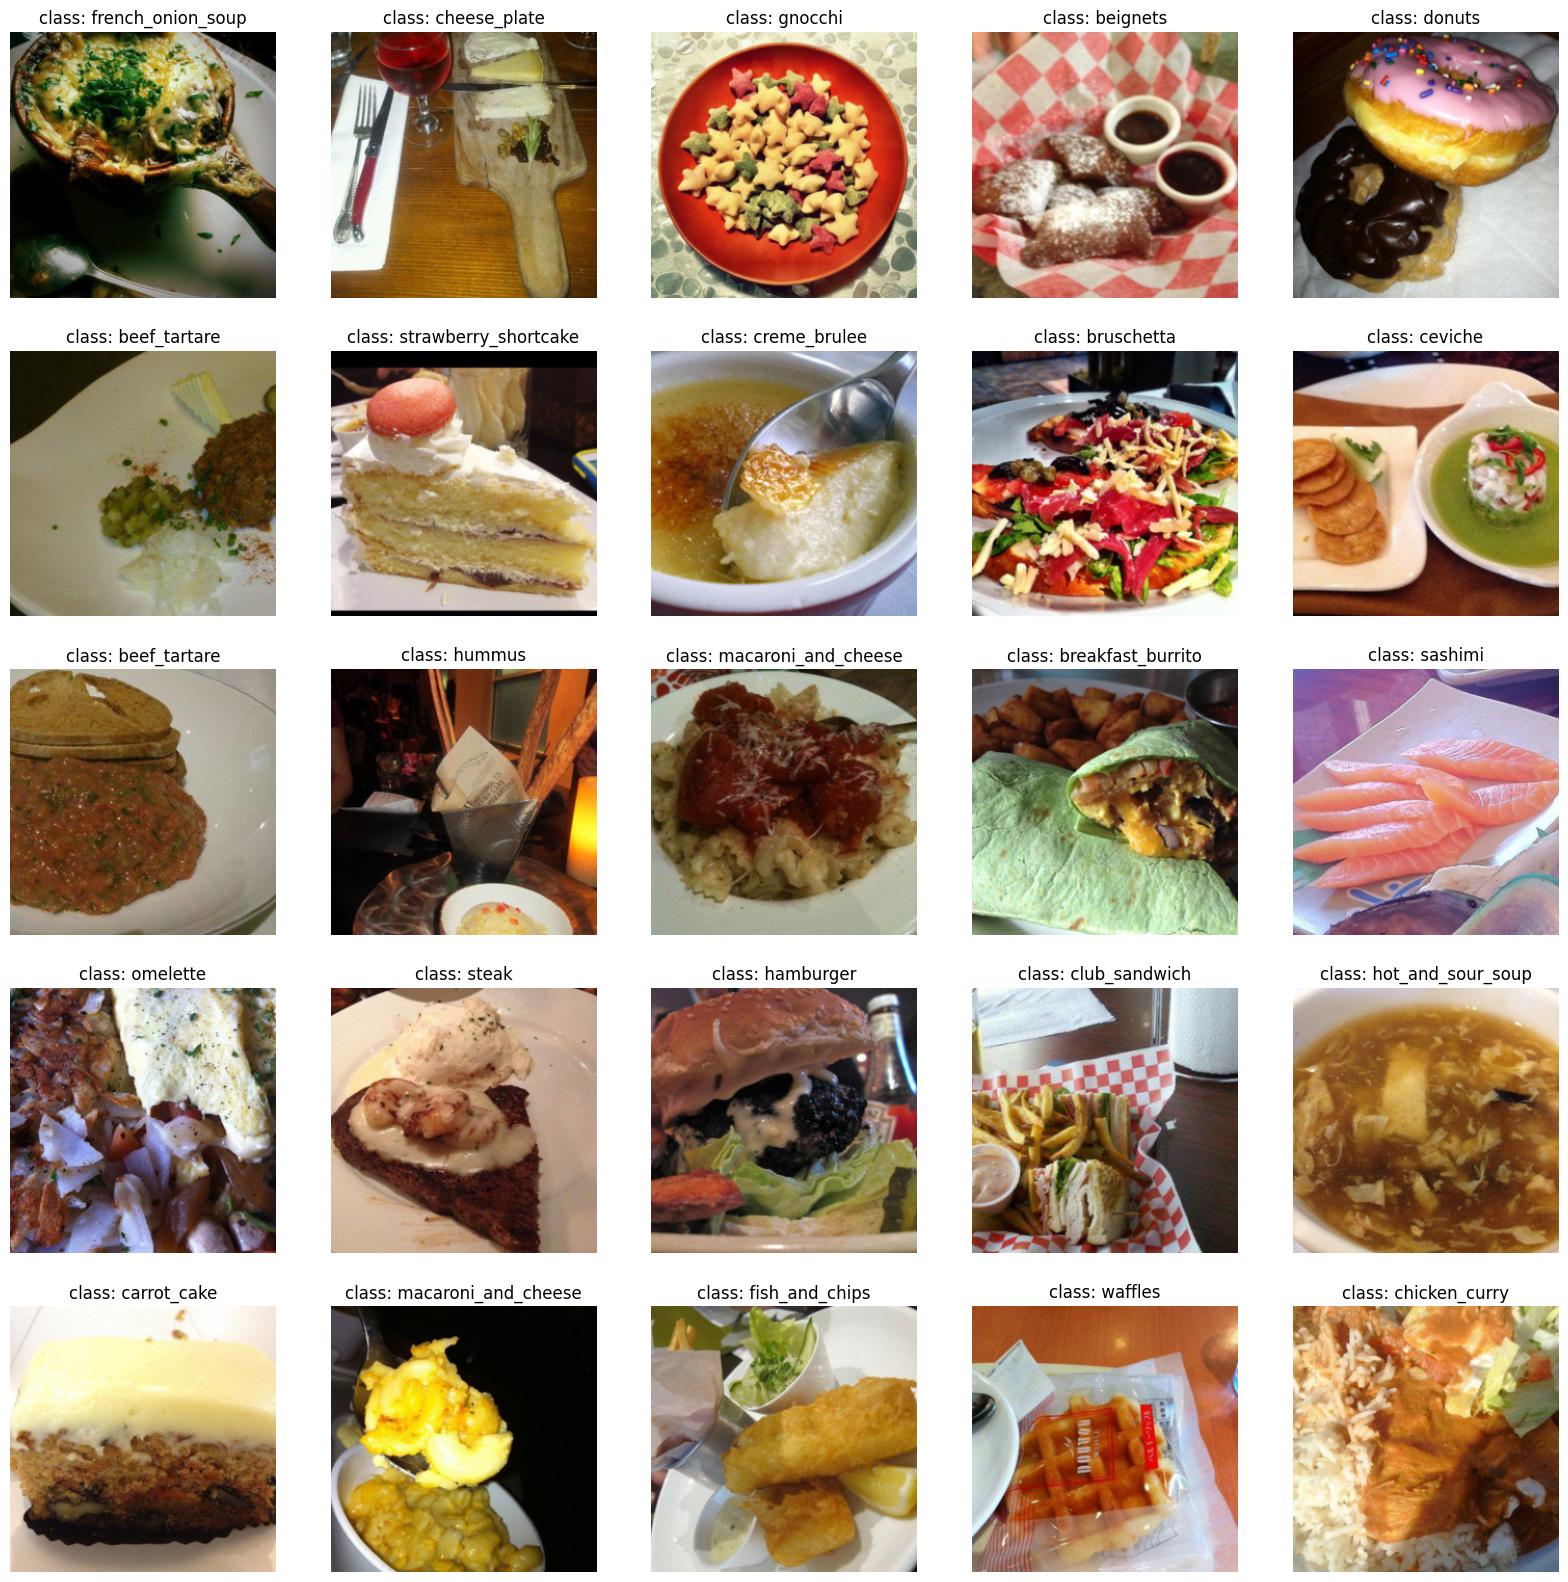

In [4]:
# Display images
manual_transforms = v2.Compose([
    v2.Resize((256)),
    v2.RandomCrop((256, 256)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

train_data = datasets.ImageFolder(TRAIN_DIR, transform=manual_transforms)
display_random_images(train_data,
                      n=25,
                      classes=train_data.classes,
                      rows=5,
                      cols=5,
                      display_shape=False,
                      seed=None)

# 6. Preparing Dataloaders

In [5]:
# Create the training and test dataloaders
IMG_SIZE_2 = 384
BATCH_SIZE = 32
train_dataloader, test_dataloader, class_names = create_dataloaders_vit(
    vit_model="vit_b_16_384", # corresponds to ViT-Base/16-384
    batch_size=BATCH_SIZE,
    train_dir=TRAIN_DIR,
    test_dir=TEST_DIR,
    aug=True,
    num_workers=NUM_WORKERS
    )

# 7. Creating a Custom Vision Transformer (ViT) Model

In [6]:
# Create the ViT-Base model
model = ViT(
    img_size=IMG_SIZE_2,
    in_channels=3,
    patch_size=16,
    num_transformer_layers=12,
    emb_dim=768,
    mlp_size=3072,
    num_heads=12,
    attn_dropout=0,
    mlp_dropout=0.1,
    emb_dropout=0.1,
    num_classes=len(class_names)
)

# Copy weights from torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1
model.copy_weights(torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1)

# Compile model
model = torch.compile(model, backend="aot_eager")

# Print summary
summary(model,
        input_size=(BATCH_SIZE,3,IMG_SIZE_2, IMG_SIZE_2),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

[INFO] Model weights copied successfully.
[INFO] Model weights are trainable by default. Use function set_params_frozen to freeze them.


c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
OptimizedModule (OptimizedModule)                                 [32, 3, 384, 384]    [32, 101]            --                   True
├─ViT (_orig_mod)                                                 [32, 3, 384, 384]    [32, 101]            --                   True
│    └─PatchEmbedding (embedder)                                  [32, 3, 384, 384]    [32, 577, 768]       443,904              True
│    │    └─Conv2d (conv_proj)                                    [32, 3, 384, 384]    [32, 768, 24, 24]    590,592              True
│    │    └─Flatten (flatten)                                     [32, 768, 24, 24]    [32, 768, 576]       --                   --
│    │    └─Dropout (emb_dropout)                                 [32, 577, 768]       [32, 577, 768]       --                   --
│    └─Sequential (encoder)                                  

# 8. Training the Model

Epoch: 20/20 | Train: | loss: 0.8292 | acc: 0.9888 | fpr: 0.0008 | pauc: 0.0500 | time:  33m14s | lr: 0.0000010000
Epoch: 20/20 | Test:  | loss: 1.0880 | acc: 0.9120 | fpr: 0.1795 | pauc: 0.0480 | time:   4m40s | lr: 0.0000010000


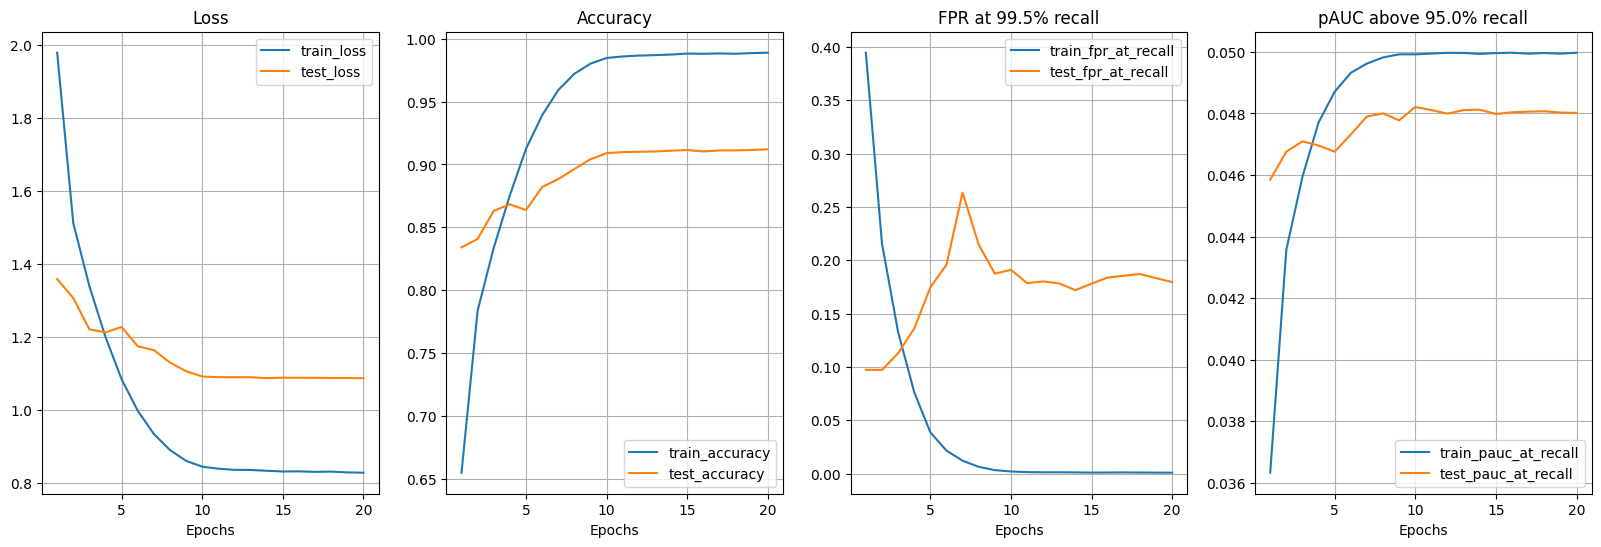

[INFO] Saving model to: models\model_epoch20.pth
[INFO] Saving model to: models\model_loss_epoch20.pth
[INFO] Saving model to: models\model_acc_epoch20.pth
[INFO] Training finished! Elapsed time: 758m28s


In [7]:
# Train the model
EPOCHS = 20
LR = 0.0001
model_type="model"
model_name = model_type + ".pth"

# Create AdamW optimizer
optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=LR,
    betas=(0.9, 0.999),
    weight_decay=0.01
)

# Create loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Set scheduler: from epoch #1 to #10 use CosinAnnealingRL, from epoch #11 to #20 a fixed learning rate
scheduler = FixedLRSchedulerWrapper(
    scheduler=CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6),
    fixed_lr=1e-6,
    fixed_epoch=10)

# Set seeds
set_seeds(SEED)

# And train...

# Instantiate the classification engine with the created model and the target device
engine = ClassificationEngine(
    model=model,
    device=device)

# Configure the training method
results = engine.train(
    target_dir=MODEL_DIR,                       # Directory where the model will be saved
    model_name=model_name,                      # Name of the model
    save_best_model=["last", "loss", "acc"],    # Save the best models based on different criteria
    keep_best_models_in_memory=False,           # Do not keep the models stored in memory for the sake of training time and memory efficiency
    train_dataloader=train_dataloader,          # Train dataloader
    test_dataloader=test_dataloader,            # Test dataloader
    optimizer=optimizer,                        # Optimizer
    loss_fn=loss_fn,                            # Loss function
    recall_threshold=0.995,                     # False positive rate at recall_threshold recall
    recall_threshold_pauc=0.95,                 # Partial AUC score above recall_threshold_pauc recall
    scheduler=scheduler,                        # Scheduler
    epochs=EPOCHS,                              # Total number of epochs
    amp=True,                                   # Enable Automatic Mixed Precision (AMP)
    enable_clipping=False,                      # Disable clipping on gradients, only useful if training becomes unestable
    debug_mode=False,                           # Disable debug mode    
    accumulation_steps=2                        # Accumulation steps 2: effective batch size = batch_size x accumulation steps
    )